# Evaluating k-means clustering

Using k-means evaluation method described by ELMOUFIDI et al. (2014), called Correct Detection Rate.

It is a measure of overlap between manually painted ground truth and k-means clustering results.

From the paper:

> To evaluate the performance of our algorithm, we calculated
> the percentage of pixels marked by the radiologist which are
> located inside the (ROIs) detected by our method (the Correct
> Detection Rate CDR). This value (CDR)is bound between
> zero (no pixel is located inside the detected (ROIs)) and one
> (all pixels are located inside the detected (ROIs)) [5]. The
> evaluation criterion is the overlapped area ratio, which is the
> ratio of the overlapped area between the detected region and
> the criterion region segmented by the radiologists manually.
> In the case of (MIAS) database, the criterion region is the
> circle formed by the coordinates of center and radius.

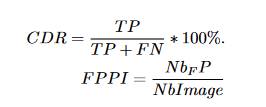

> where TP True Positives, FN False Negatives and Nb FP
> is the number of False Positives and Nb Image is the total
> number of image per cluster.

In [1]:
from spectral import *
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pickle as pkl
import os
from os.path import exists
from matplotlib import cm

In [2]:
dir_fn = "processed-data/sardi-capture-final/final/reflectance/2023_03_28/food_and_waste"
# dir_fn = "processed-data/sardi-capture-final/final/reflectance/2023_03_28/just_waste"

In [3]:
def process_into_rgb(loc_ds):
    """
    Processes a given dataset into an rgb image for display
    """
    loc_dc = np.array(loc_ds['datacube']).transpose(1,2,0)
    loc_binned_wavelengths = np.array(loc_ds['wavelength'])

    red_nm = 640
    green_nm = 550
    blue_nm = 470
    
    rgb = np.zeros( (*loc_dc.shape[:2],3), dtype=np.float32)
    rgb[...,0] = loc_dc[:,:,np.argmin(np.abs(loc_binned_wavelengths-red_nm))]
    rgb[...,1] = loc_dc[:,:,np.argmin(np.abs(loc_binned_wavelengths-green_nm))]
    rgb[...,2] = loc_dc[:,:,np.argmin(np.abs(loc_binned_wavelengths-blue_nm))]
    
    rgb = np.minimum(np.maximum(rgb, 0), 1)

    rgb *= 255
    rgb = rgb.astype(np.uint8)
    
    return rgb

In [4]:
dir_cont = os.listdir(dir_fn)

data_cubes = [cont for cont in dir_cont if '.nc' in cont]
print(sorted(data_cubes))

['2023_03_28-02_16_51.nc', '2023_03_28-02_19_32.nc', '2023_03_28-02_21_43.nc', '2023_03_28-02_23_58.nc', '2023_03_28-02_26_42.nc', '2023_03_28-02_29_35.nc', '2023_03_28-02_33_10.nc', '2023_03_28-02_35_15.nc']


In [5]:
gnd_t_fns = []
class_fns = []
fn_paths = []

In [6]:
for fn in data_cubes:
    fn_path = dir_fn + '/' + fn
    fn_paths.append(fn_path)
    gnd_t_fns.append(fn_path.split('.')[0] + "-gnd_t.pkl")
    class_fns.append(fn_path.split('.')[0] + "_classification-waste.pkl")

In [7]:
ds = nc.Dataset(fn_paths[0].replace("reflectance","radiance"))

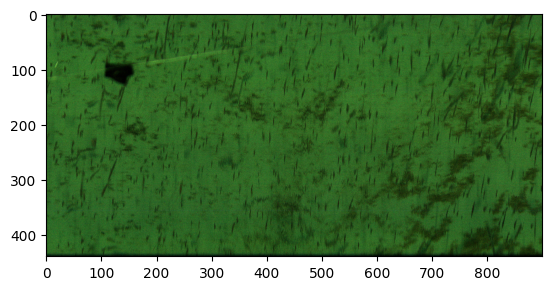

In [8]:
image = process_into_rgb(ds)
plt.imshow(image)

In [9]:
# assuming target saved with background = 0 and target = 1
class_wastes = []

for class_fn in class_fns:
    with open(class_fn, 'rb') as in_file:
        class_wastes.append(pkl.load(in_file))
    

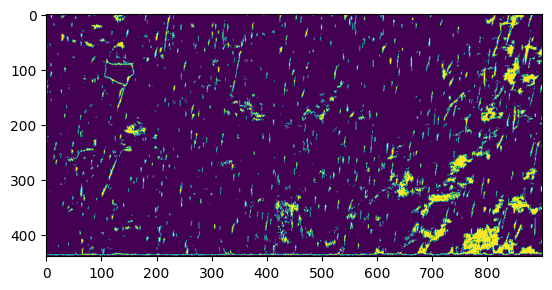

In [10]:
plt.imshow(class_wastes[0])

In [11]:
gnd_ts = []

for gnd_t_fn in gnd_t_fns:
    with open(gnd_t_fn, 'rb') as in_file:
        gnd_ts.append(pkl.load(in_file))
    

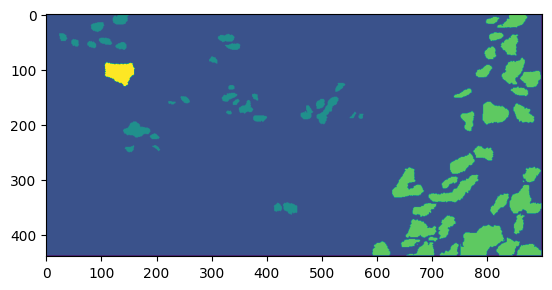

In [12]:
plt.imshow(gnd_ts[0])

Just check that the target class is correct, all gts have the same classes so once is enough.

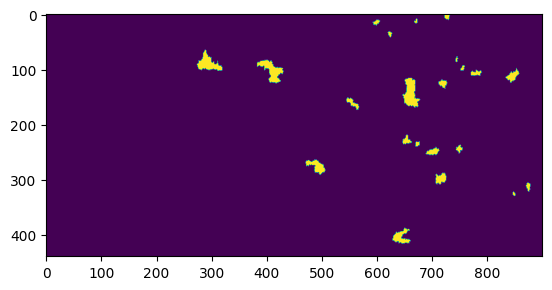

In [28]:
# must locate target in image
gnd_t_waste = gnd_ts[0].copy()

target = 2

idx = gnd_ts[0] != target
idx_target = gnd_ts[0] == target

gnd_t_waste[idx]= 0
gnd_t_waste[idx_target]= 1

plt.imshow(gnd_t_waste)

In [29]:
cdrs = {}

for i in range(len(data_cubes)):
    
    # must locate target in image
    gnd_t_waste = gnd_ts[i].copy()

    target = 2

    idx = gnd_ts[i] != target
    idx_target = gnd_ts[i] == target

    # set background to something not 1 or the background of the classification, 0.
    gnd_t_waste[idx]= 0
    gnd_t_waste[idx_target]= 1

    class_waste = class_wastes[i]

    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    # This assumes that the gnd_t and class are both 1 when true and 0 when false
    
    print(str(i) + ' evaluating '+data_cubes[i].split('.')[0])
          
    for x in range(class_waste.shape[0]-1):
        for y in range(class_waste.shape[1]-1):
            # calculate classification metrics
            if gnd_t_waste[x,y] == class_waste[x,y] == 1: # true positive, both gt and classified classes match
                tp += 1
            elif gnd_t_waste[x,y] == 1 and class_waste[x,y] != 1: # false negative, gt and classified should match but classified doesn't
                fn += 1
            elif gnd_t_waste[x,y] != 1 and class_waste[x,y] == 1: # false positive, gt is not the class, but classified is
                fp += 1
            elif gnd_t_waste[x,y] != 1 and class_waste[x,y] != 1: # true negative the ground truth and the classified don't match
                tn += 1
                
    print('tp: ' + str(tp) + ', fn: ' + str(fn) + ', fp: ' + str(fp) + ', tn: ' + str(tn))

    cdrs[data_cubes[i].split('.')[0]]=(tp/(tp+fn))*100

0 evaluating 2023_03_28-01_54_05
tp: 4160, fn: 1446, fp: 42352, tn: 345804
1 evaluating 2023_03_28-01_45_56
tp: 3676, fn: 1697, fp: 26313, tn: 362076
2 evaluating 2023_03_28-01_56_37
tp: 3961, fn: 1546, fp: 25655, tn: 362600
3 evaluating 2023_03_28-01_51_30
tp: 3288, fn: 1212, fp: 46322, tn: 342940
4 evaluating 2023_03_28-01_48_52
tp: 3476, fn: 1119, fp: 44983, tn: 344184
5 evaluating 2023_03_28-01_58_54
tp: 2398, fn: 1951, fp: 9726, tn: 379687


In [30]:
print(cdrs)

{'2023_03_28-01_54_05': 74.20620763467713, '2023_03_28-01_45_56': 68.41615484831566, '2023_03_28-01_56_37': 71.92663882331578, '2023_03_28-01_51_30': 73.06666666666666, '2023_03_28-01_48_52': 75.6474428726877, '2023_03_28-01_58_54': 55.1391124396413}


# Results

CDRs for food and waste:

```
{'2023_03_28-02_33_10': 29.296653431650594, '2023_03_28-02_19_32': 39.53881954728157, '2023_03_28-02_23_58': 72.00435729847494, '2023_03_28-02_35_15': 37.338696162225574, '2023_03_28-02_21_43': 41.67761306061175, '2023_03_28-02_16_51': 38.5868026054942, '2023_03_28-02_29_35': 42.195470312181186, '2023_03_28-02_26_42': 34.291938997821354}
```

For just waste:

```
{'2023_03_28-01_54_05': 74.20620763467713, '2023_03_28-01_45_56': 68.41615484831566, '2023_03_28-01_56_37': 71.92663882331578, '2023_03_28-01_51_30': 73.06666666666666, '2023_03_28-01_48_52': 75.6474428726877, '2023_03_28-01_58_54': 55.1391124396413}
```